In [1]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
#from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import shutil

2023-05-19 16:23:15.992629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Unzipping

In [2]:
    folder_path_train = os.path.join("..", "data", "asl_alphabet_train", "asl_alphabet_train") # Path to the data if unzipped already
    if not os.path.exists(folder_path_train): # Checking to see if folder is unzipped
        print("Unzipping file...")
        path_to_zip = os.path.join("..","data","archive1.zip") # Defining the path to the zip file
        zip_destination = os.path.join("..", "data") # defining the output destination

        with zipfile.ZipFile(path_to_zip,"r") as zip_ref: # using the package from zipfile, to un zip the zip file
            zip_ref.extractall(zip_destination)
    print("The files are unzipped")

The files are unzipped


## Unzipping test images

In [3]:
    folder_path_test = os.path.join("..", "data", "real_test_images") # Path to the data if unzipped already
    if not os.path.exists(folder_path_test): # Checking to see if folder is unzipped
        print("Unzipping file")
        os.makedirs(folder_path) # Making the folder real_test_images
        path_to_zip = os.path.join("..","data","archive2.zip") # Defining the path to the zip file
        zip_destination = os.path.join("..", "data", "real_test_images") # defining the output destination

        with zipfile.ZipFile(path_to_zip,"r") as zip_ref: # using the package from zipfile, to un zip the zip file
            zip_ref.extractall(zip_destination)
    print("The files are unzipped")

The files are unzipped


## Deleting folders

### Deleting folders for real_test_images
- folder_path_train and folder_path_test is used 

In [4]:

folders_to_delete = ["asl-alphabet-test", "del", "nothing", "space"]  # List of folders to delete

for folder_name in folders_to_delete:
    folder_path = os.path.join(folder_path_train, folder_name) # Getting folder_path_test from unzip function 
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder: {folder_path} does not exists")

folder_path_asl_test = os.path.join("..","data","asl_alphabet_test")
if os.path.exists(folder_path_asl_test):
    shutil.rmtree(folder_path_asl_test)
    print(f"Deleted folder_ {folder_path_asl_test}")
else:
    print(f"{folder_path_asl_test} is already deleted")

Folder: ../data/asl_alphabet_train/asl_alphabet_train/asl-alphabet-test does not exists
Folder: ../data/asl_alphabet_train/asl_alphabet_train/del does not exists
Folder: ../data/asl_alphabet_train/asl_alphabet_train/nothing does not exists
Folder: ../data/asl_alphabet_train/asl_alphabet_train/space does not exists
../data/asl_alphabet_test is already deleted


## Train and validation generator 

In [5]:

    print("Creating Image data generator")
    # ImageDataGenerator from tensorflow 
    datagen = ImageDataGenerator(horizontal_flip=True,
                                validation_split = 0.2, # Flip it horizontally around the access randomly 
                                 # Rotate the image randomly 20 degress around the access
                                rescale = 1/255 # rescale the pixel values to between 0-1
                                
    )


Creating Image data generator


In [6]:
directory = os.path.join("..","data","asl_alphabet_train", "asl_alphabet_train")

In [7]:
training_tensorflow = datagen.flow_from_directory(
    folder_path_train, # Getting folder from un zip function
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=None,
    #save_to_dir=None,
    #save_prefix='',
    #save_format='png',
    #follow_links=False,
    subset="training",
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 62400 images belonging to 26 classes.


In [8]:
validation_tensorflow = datagen.flow_from_directory(
    folder_path_train,
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=None,
    #save_to_dir=None,
    #save_prefix='',
    #save_format='png',
    #follow_links=False,
    subset="validation",
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 15600 images belonging to 26 classes.


## Test images

In [9]:
directory_test = os.path.join("..","data","real_test_images")

## dataframe creation for train images for enabling sampling

In [36]:

# Set the path to the directory containing your data
data_dir = os.path.join("..","data","asl_alphabet_train","asl_alphabet_train")



# Initialize lists to store image paths and labels
image_paths = []
labels = []
images = []

# Iterate through each letter folder in the data directory
for label_folder in os.listdir(data_dir):
    letter_folder = os.path.join(data_dir, label_folder)

    # Iterate through each image file in the letter folder
    for filename in os.listdir(letter_folder):
        image_path = os.path.join(letter_folder, filename)
        images.append(image_path)
        # Append the image path and label to the respective lists
        image_paths.append(image_path)
        labels.append(label_folder)

# Create a DataFrame from the image_paths and labels lists
train_df = pd.DataFrame({'image_path': image_paths, 'label': labels})





In [37]:
train_df = train_df.sample(n=10000)

## Test datagenerator 

In [25]:
    test_datagen = ImageDataGenerator(                 
                                    rescale = 1./255. # Datagenerator for test, it only has to rescale the images 
    )

## Test flow from dir

In [49]:
test_tensorflow_ = test_datagen.flow_from_directory(
    folder_path_test,
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=None,
    #save_to_dir=None,
    #save_prefix='',
    #save_format='png',
    #follow_links=False,
    subset=None,
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 780 images belonging to 26 classes.


## Train dataframe

In [40]:
training_tensorflow = test_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=None,
    interpolation='nearest',
    keep_aspect_ratio=False
)

#["A","B","C","D","E","F","G","H","J","K","L","M","N","P","Q","R","S","T","U","V","W","X","Y","Z"],

Found 10000 validated image filenames belonging to 26 classes.


In [12]:

    print("Loading model: ")  
    # load model without classifier layers
    model = VGG16(include_top=False, # Exclude classifier layers
                pooling='avg',
                input_shape=(90, 90, 3)) # Input shape of the images. 224 pixels by 224. 3 color channels

    # Keep pretrained layers, and don't modify them
    for layer in model.layers:
        layer.trainable = False
        
    # Add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    bn = BatchNormalization()(flat1) # Added batnormalization from tensorflow. Take the previouslayer, normalise the values, and than pass them on
    class1 = Dense(256, 
                activation='relu')(bn) # Added new classification layer 
    class2 = Dense(128, 
                activation='relu')(class1) # Added new classification layer with 15 outputs. 15 labels in total
    output = Dense(26, # 15 labels
                activation='softmax')(class2)

    # define new model
    model = Model(inputs=model.inputs, 
                outputs=output)

    # compile
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, # Start learning rate at 0.01
        decay_steps=10000, # Every 10 000 steps start decaying 
        decay_rate=0.9) # DEcay by 0.9 to the start learning rate
    sgd = SGD(learning_rate=lr_schedule)

    model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # summarize
    print(model.summary())
    

Loading model: 
58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 90, 90, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 90, 90, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 45, 45, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 45, 45, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 45, 45, 128)       147584    
                                              

In [43]:
    H = model.fit( # fitting the model to 
        training_tensorflow, # training data from tensorflow dataframe 
        steps_per_epoch = len(training_tensorflow), # Take as many steps as the length of the dataframe 
        validation_data = validation_tensorflow, # Validation data from tensorflow dataframe
        validation_steps = len(validation_tensorflow), # Validation steps as length of validation data 
        epochs = 5)

Epoch 1/5


2023-05-19 17:25:57.697384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


313/313 [==============================] - 190s 609ms/step - loss: 0.7275 - accuracy: 0.8345 - val_loss: 1.2914 - val_accuracy: 0.6387
Epoch 2/5
313/313 [==============================] - 126s 402ms/step - loss: 0.5438 - accuracy: 0.8781 - val_loss: 1.2082 - val_accuracy: 0.6621
Epoch 3/5
313/313 [==============================] - 126s 402ms/step - loss: 0.4295 - accuracy: 0.9063 - val_loss: 1.2640 - val_accuracy: 0.6646
Epoch 4/5
313/313 [==============================] - 126s 403ms/step - loss: 0.3530 - accuracy: 0.9245 - val_loss: 1.2152 - val_accuracy: 0.6837
Epoch 5/5
313/313 [==============================] - 126s 404ms/step - loss: 0.2961 - accuracy: 0.9377 - val_loss: 1.2589 - val_accuracy: 0.6819


## Predictions

In [51]:
    pred = model.predict(test_tensorflow_) # Using test data on the model
    pred = np.argmax(pred,axis=1)

    # Map the label 
    labels = (training_tensorflow_.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

2023-05-19 17:53:16.595030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 37s 6s/step


## Classifier report

In [52]:
    y_true = test_df['label'].values # Test labels from dataframe
    classification_report_test = classification_report(y_true, pred) # Create classification report with labels, and predictions
    print("Classification Report - Test Data:")
    print(classification_report_test)

ValueError: Found input variables with inconsistent numbers of samples: [10000, 780]

In [53]:
true_labels = test_tensorflow_.classes

# Convert labels to numerical values
label_map = {v: k for k, v in training_tensorflow.class_indices.items()}
true_labels = np.array([label_map[label] for label in true_labels])

# Print the classification report
print(classification_report(true_labels, pred))


              precision    recall  f1-score   support

           A       0.03      0.03      0.03        30
           B       0.00      0.00      0.00        30
           C       0.00      0.00      0.00        30
           D       0.04      0.13      0.06        30
           E       0.07      0.10      0.08        30
           F       0.03      0.03      0.03        30
           G       0.04      0.27      0.07        30
           H       0.18      0.07      0.10        30
           I       0.00      0.00      0.00        30
           J       0.05      0.07      0.06        30
           K       0.00      0.00      0.00        30
           L       0.25      0.03      0.06        30
           M       0.00      0.00      0.00        30
           N       0.05      0.03      0.04        30
           O       0.06      0.03      0.04        30
           P       0.00      0.00      0.00        30
           Q       0.00      0.00      0.00        30
           R       0.08    

## Plotting history 

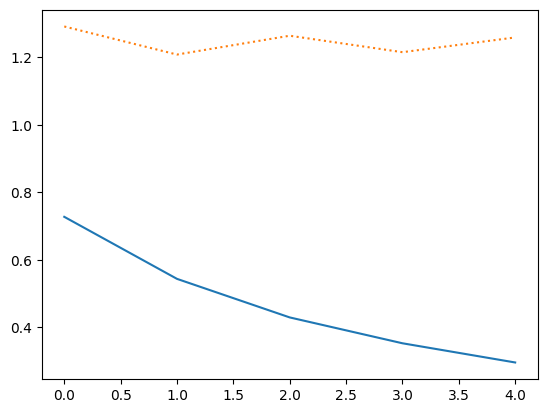

In [47]:
plt.plot(np.arange(0,5), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, 5), H.history["val_loss"], label="val_loss", linestyle=":")